In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models

# Any results you write to the current directory are saved as output.

from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage import io, transform
import torch.utils.data as data_utils

['train', 'labels.csv', 'sample_submission.csv', 'test']


In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [4]:
class DogBreedsDataset(Dataset):
    """Dog Breeds dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)
        self.map = dict(zip(self.labels_frame['breed'].unique(),range(0,len(self.labels_frame['breed'].unique()))))
        self.labels_frame['breed'] = self.labels_frame['breed'].map(self.map)
        self.root_dir = root_dir
        self.transform = transform
        
    def getmap(self):
        return self.map
        
    def __getclasses__(self):
        return self.labels_frame['breed'].unique().tolist()

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.labels_frame.iloc[idx, 0])
        img_name = img_name + '.jpg'
        
        image = io.imread(img_name)
        PIL_image = Image.fromarray(image)
        label = self.labels_frame.iloc[idx, 1:]
        label = [int(label) for x in label]
        label = np.asarray(label)
        label = torch.from_numpy(label)
        if self.transform:
            image = self.transform(PIL_image)
        #sample = {'image': image, 'label': label}
        return image,label

In [5]:
class DogBreedsTestset(Dataset):
    """Dog Breeds Test dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)
        self.labels_frame = self.labels_frame[['id']]
        self.root_dir = root_dir
        self.transform = transform
   
    def __len__(self):
        return len(self.labels_frame)


    def __getitem__(self, idx):
        title = self.labels_frame.iloc[idx, 0]
        img_name = os.path.join(self.root_dir,
                                title)
        img_name = img_name + '.jpg'
        
        image = io.imread(img_name)
        PIL_image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(PIL_image)
        sample = {'image': image, 'title': title}
        return sample

In [6]:
data_dir = '../input'

# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


# TODO: Define transforms for the training data and testing data
transform = transforms.Compose([transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transforms = transforms.Compose([
                                      transforms.ToTensor()])

train_data = DogBreedsDataset(csv_file='../input/labels.csv',root_dir='../input/train', transform=transform)
#test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
classes = train_data.__getclasses__()
print(classes)
#obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


In [7]:
df_test = pd.read_csv('../input/sample_submission.csv')
df_test.head(1)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [8]:
test_data = DogBreedsTestset(csv_file='../input/sample_submission.csv',root_dir='../input/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20)

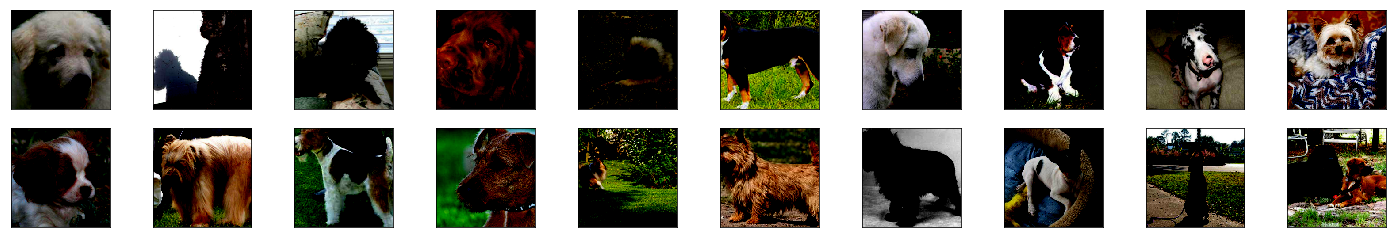

In [9]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    #ax.set_title(classes[labels[idx]])

In [10]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:10<00:00, 51983280.68it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [11]:

# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [12]:
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

120


In [13]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [14]:
# number of epochs to train the model
n_epochs = 15

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    # model by default is set to train
    
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
       
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, torch.max(target, 1)[1])
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.9011059612035752
Epoch 1, Batch 40 loss: 0.1695058476179838
Epoch 1, Batch 60 loss: 0.0754924879409373
Epoch 1, Batch 80 loss: 0.0431268538348377
Epoch 1, Batch 100 loss: 0.0381977605167776
Epoch 1, Batch 120 loss: 0.0297892009373754
Epoch 1, Batch 140 loss: 0.0223400664050132
Epoch 1, Batch 160 loss: 0.0152656221529469
Epoch 1, Batch 180 loss: 0.0142557752318680
Epoch 1, Batch 200 loss: 0.0128294826019555
Epoch 1, Batch 220 loss: 0.0086360657238401
Epoch 1, Batch 240 loss: 0.0129966866341420
Epoch 1, Batch 260 loss: 0.0090028882259503
Epoch 1, Batch 280 loss: 0.0084554457804188
Epoch 1, Batch 300 loss: 0.0091100441408344
Epoch 1, Batch 320 loss: 0.0066498875617981
Epoch 1, Batch 340 loss: 0.0054340576985851
Epoch 1, Batch 360 loss: 0.0053033161326312
Epoch 1, Batch 380 loss: 0.0059863865259103
Epoch 1, Batch 400 loss: 0.0052910923957825
Epoch 2, Batch 20 loss: 0.0050383866124321
Epoch 2, Batch 40 loss: 0.0052604461088777
Epoch 2, Batch 60 loss: 0.004322081798

In [15]:
valid_loss = 0.0
vgg16.eval()
for batch_i, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
       
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, torch.max(target, 1)[1])
        
        # update training loss 
        valid_loss += loss.item()
        
        if batch_i % 20 == 19:    # print validation loss every specified number of mini-batches
            print('Validation Loss Batch %d loss: %.16f' %
                  (batch_i + 1, valid_loss / 20))
            valid_loss = 0.0

Validation Loss Batch 20 loss: 0.0002161884267480
Validation Loss Batch 40 loss: 0.0004075682147231
Validation Loss Batch 60 loss: 0.0004051399271702
Validation Loss Batch 80 loss: 0.0004298460477003
Validation Loss Batch 100 loss: 0.0003044271494218


In [16]:
results = {}
vgg16.eval()

for (_,data) in enumerate(test_loader):
        # move tensors to GPU if CUDA is available
        images,titles = data['image'], data['title']
               
        if train_on_gpu:
            images = images.cuda()
        #print(title)
        logits = vgg16(images)
        output = torch.nn.functional.softmax(logits, dim=1)
        
        for k in range(len(titles)):
            name = titles[k]
            results[name] = output[k].cpu().tolist()

In [17]:
output_df = pd.DataFrame(results).transpose()

In [18]:
inv_map = {v: k for k, v in train_data.getmap().items()}
inv_map

{0: 'boston_bull',
 1: 'dingo',
 2: 'pekinese',
 3: 'bluetick',
 4: 'golden_retriever',
 5: 'bedlington_terrier',
 6: 'borzoi',
 7: 'basenji',
 8: 'scottish_deerhound',
 9: 'shetland_sheepdog',
 10: 'walker_hound',
 11: 'maltese_dog',
 12: 'norfolk_terrier',
 13: 'african_hunting_dog',
 14: 'wire-haired_fox_terrier',
 15: 'redbone',
 16: 'lakeland_terrier',
 17: 'boxer',
 18: 'doberman',
 19: 'otterhound',
 20: 'standard_schnauzer',
 21: 'irish_water_spaniel',
 22: 'black-and-tan_coonhound',
 23: 'cairn',
 24: 'affenpinscher',
 25: 'labrador_retriever',
 26: 'ibizan_hound',
 27: 'english_setter',
 28: 'weimaraner',
 29: 'giant_schnauzer',
 30: 'groenendael',
 31: 'dhole',
 32: 'toy_poodle',
 33: 'border_terrier',
 34: 'tibetan_terrier',
 35: 'norwegian_elkhound',
 36: 'shih-tzu',
 37: 'irish_terrier',
 38: 'kuvasz',
 39: 'german_shepherd',
 40: 'greater_swiss_mountain_dog',
 41: 'basset',
 42: 'australian_terrier',
 43: 'schipperke',
 44: 'rhodesian_ridgeback',
 45: 'irish_setter',
 46

In [19]:
output_df.rename(columns=inv_map,inplace=True)
output_df = output_df.reset_index()
output_df.rename(columns={'index':'id'},inplace=True)

In [20]:
output_df.to_csv('output.csv',index=False)